In [1]:
import os, sys
import h5py
import numpy as np
import matplotlib.pyplot as plt

import TimestreamHelperFunctions as Thf

In [2]:
%matplotlib notebook

In [3]:
series    = '20220721_124011'
data_path = os.path.join('/data/USRP_Noise_Scans',series.split('_')[0],series)

In [4]:
sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
# metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)

Line Delay file:  /data/USRP_Noise_Scans/20220721/20220721_124011/USRP_Delay_20220721_124011.h5
VNA scan file:    /data/USRP_Noise_Scans/20220721/20220721_124011/USRP_VNA_20220721_124011.h5
Timestream files: ['/data/USRP_Noise_Scans/20220721/20220721_124011/USRP_Noise_20220721_124011_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220721/20220721_124011/noise_averages_20220721_124011.h5


In [5]:
def readDataFile(data_path):
    sum_file, dly_file, vna_file, tone_files = Thf.GetFiles(series, verbose=True)
#     metadata, avg_frqs, avg_S21s = Thf.UnpackSummary(sum_file)
    
    f_tone = h5py.File(tone_files[0], 'r')
    
    res_ts = np.array(f_tone['raw_data0']['A_RX2']['data'])[0,:]
    n_pts  = len(res_ts)
    
    times  = np.arange(n_pts)/1e6 #*100
#     times  = np.arange(n_pts)/metadata['rate'] *100
    mags   = abs(res_ts)
    phases = np.angle(res_ts)
    
    res = dict()
    res['Phase']=phases#-np.angle(avg_S21s[0])
    res['Magnitude']=mags#-abs(avg_S21s[0])
    res['Time']=times
    res['Fs']=1e6
    res['number_samples']=n_pts
    res['chan_names']=['Phase','Magnitude']
    res['cut_idx'] = np.argmin(np.abs(times-0.001))
    return res

Line Delay file:  /data/USRP_Noise_Scans/20220721/20220721_124011/USRP_Delay_20220721_124011.h5
VNA scan file:    /data/USRP_Noise_Scans/20220721/20220721_124011/USRP_VNA_20220721_124011.h5
Timestream files: ['/data/USRP_Noise_Scans/20220721/20220721_124011/USRP_Noise_20220721_124011_delta0.h5']
Summary file:	 /data/USRP_Noise_Scans/20220721/20220721_124011/noise_averages_20220721_124011.h5


<IPython.core.display.Javascript object>


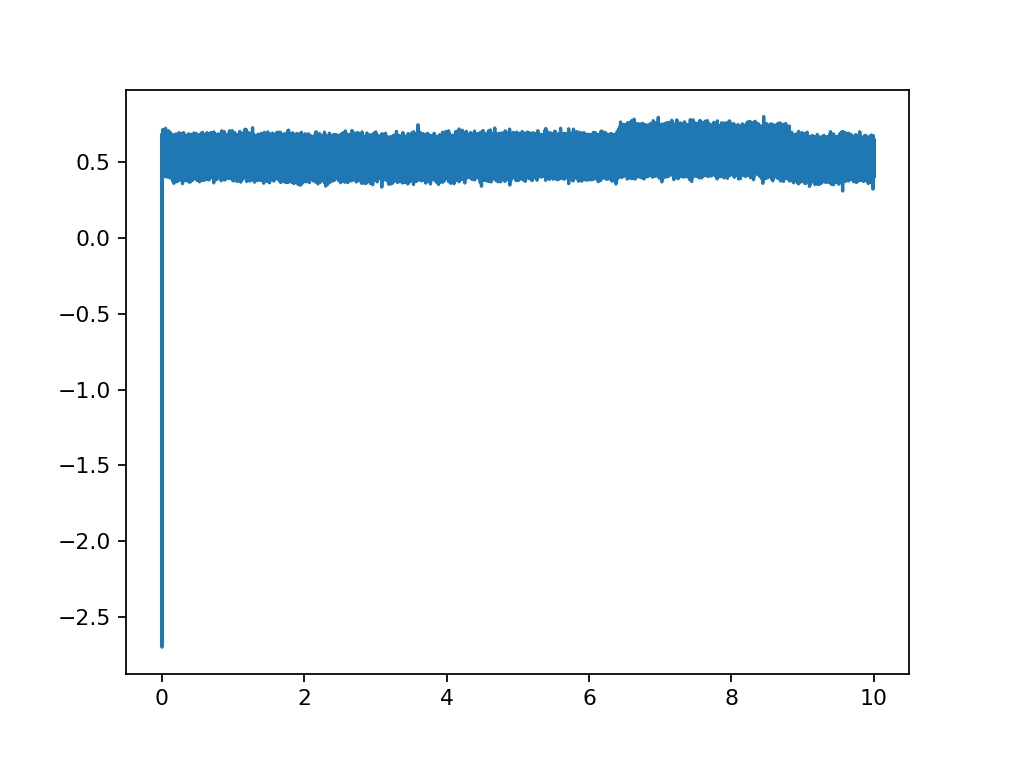

In [6]:
## 1 sample per microsecond
## laser on for ten samples
## 100 pulses per second
## 0.01 second between pulse starts --> 10^4 samples

res=readDataFile(tone_files[0])

fig = plt.figure()
ax0 = fig.gca()

ax0.plot(res["Time"],res["Phase"])

# ax0.set_xlim([9.0,15.0])
# ax0.set_ylim([0.4,0.8])

pulse0_T = 9.285

<IPython.core.display.Javascript object>


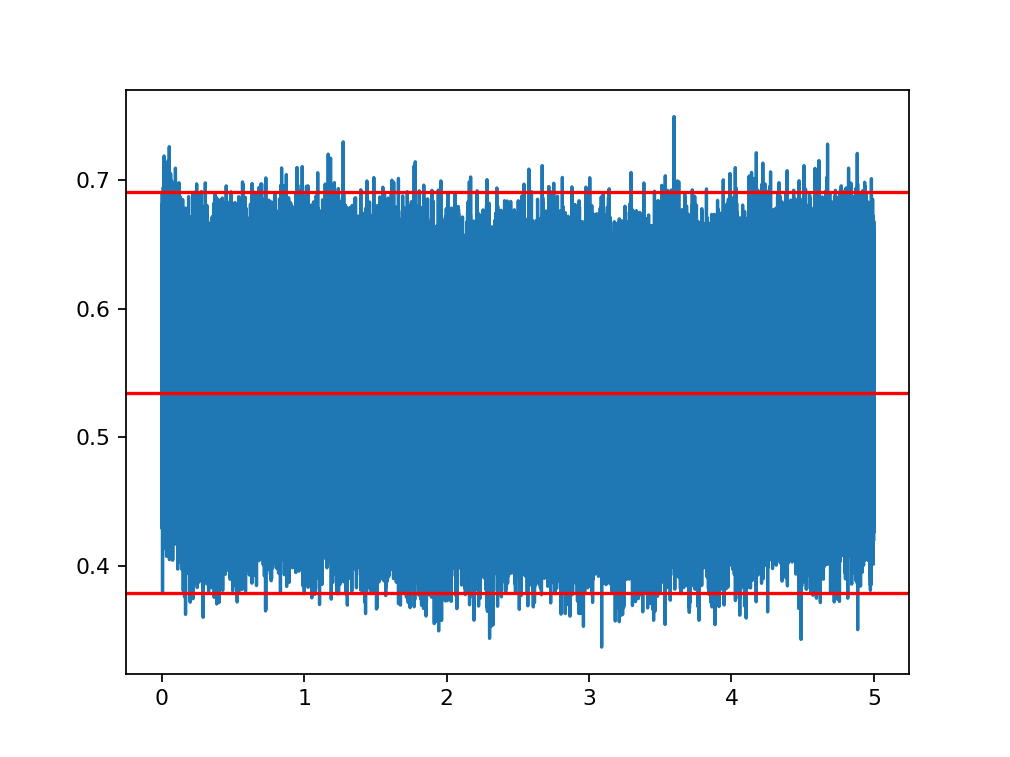

<IPython.core.display.Javascript object>


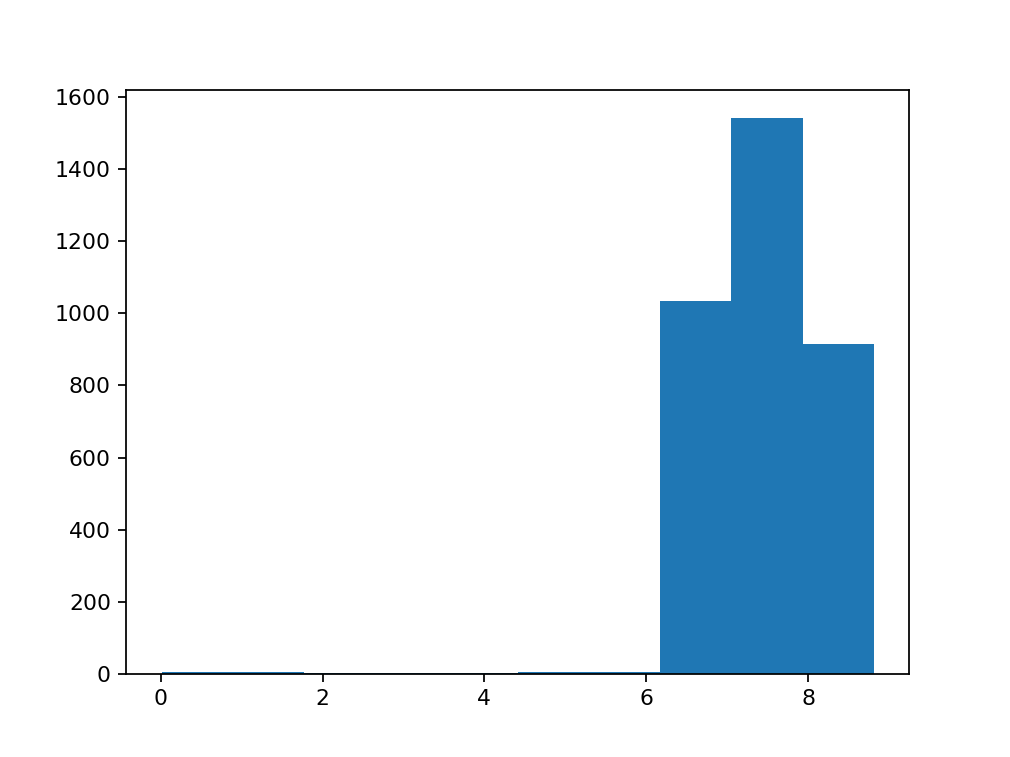

[ 1.00e+00 -4.00e+00  0.00e+00  2.00e+00  2.00e+00  0.00e+00  1.03e+03
  5.08e+02 -6.29e+02]
1030.0
6.1730629


<IPython.core.display.Javascript object>


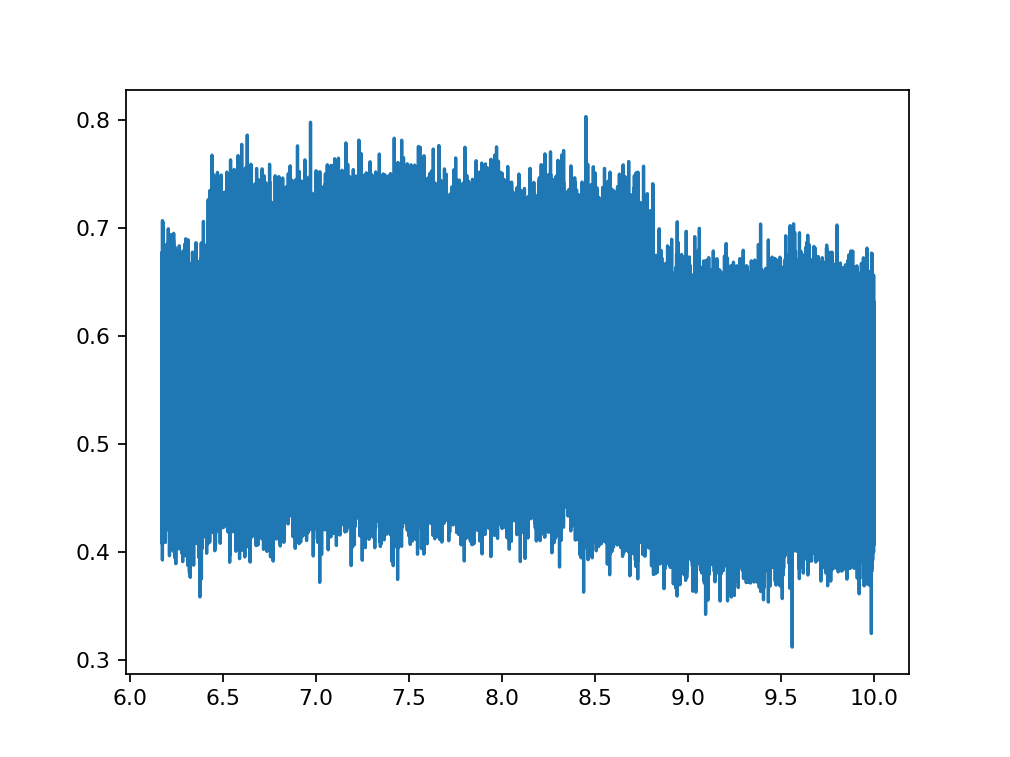

In [9]:
y_vals = res["Phase"][50:]
t_vals = np.arange(len(y_vals))/1e6
n_pts  = len(y_vals)

## First half of timestream
cutoff = int(0.5 * n_pts)
mean   = np.mean(y_vals[:cutoff])
sdev   = np.std( y_vals[:cutoff])

fig = plt.figure()
ax0 = fig.gca()
ax0.plot(t_vals[:cutoff],y_vals[:cutoff])
ax0.axhline(y=mean,c='r')
ax0.axhline(y=mean+4.0*sdev,c='r')
ax0.axhline(y=mean-4.0*sdev,c='r')

# t = np.zeros(len(y_vals)-50)
# s = np.zeros(len(y_vals)-50)
# for i in np.arange(len(y_vals)-50):
#     t[i] = 

new_ys = np.copy(y_vals)
new_ys[y_vals<mean+4.5*sdev] = np.nan

fig = plt.figure()
ax0 = fig.gca()
# ax0.scatter(t_vals,new_ys)
cts, edges, f = ax0.hist(t_vals[y_vals > mean+4.5*sdev])
print(cts[1:]-cts[:-1])
print(np.max(cts[1:]-cts[:-1]))
t_guess = edges[1+np.argmax(cts[1:]-cts[:-1])]
print(t_guess)


fig = plt.figure()
ax0 = fig.gca()
ax0.plot(t_vals[t_vals>t_guess],y_vals[t_vals>t_guess])

In [12]:
## Eyeball start and end times, then N pulses is
def EstimateNpulses(start, end, pulse_rate_Hz=100):
    return (end-start)*pulse_rate_Hz

## Can we programatically find the region of increased activity
def EstimateStartAndNpulses(timestream, pulse_rate_Hz=100, sample_rate=1e6):
    start_t  = None
    N_pulses = None
    return start_t, N_pulses

In [13]:
def StackPulses(timestream, start_t_sec, pulse_rate_Hz=100, win_fac=0.90, sample_rate=1e6, Npulses=None, 
                bl_subtract=False, show_plots=False):
    ## Convert times to samples
    start_samp     = int(sample_rate * start_t_sec)
    t_btwn_pulses  = 1./pulse_rate_Hz
    samps_btwn_pls = int(sample_rate * t_btwn_pulses)
    
    ## Define the window of interest
    if win_fac > 0.95:
        win_fac = 0.95
    window = int(win_fac * samps_btwn_pls)
    
    ## Take the average of the second 5 windows in the timestream to determine a baseline
    baseline = np.mean(timestream[window:6*window])
    
    ## Subtract off the baseline from the waveform
    waveform = timestream 
    if bl_subtract:
        waveform-= baseline
    
    ## Create a storage container for the averaged waveform
    avg_wvfm = np.zeros(window)
    
    ## Initialize the plot
    if show_plots:
        fig = plt.figure()
        ax0 = fig.gca()
        
    ## Loop from the first pulse until the end of the timestream
    i = 0
    while start_samp+i*samps_btwn_pls+window < len(res["Phase"])-1:
        avg_wvfm +=  waveform[start_samp+i*samps_btwn_pls:start_samp+i*samps_btwn_pls+window]
        if show_plots:
            ax0.plot(waveform[start_samp+i*samps_btwn_pls:start_samp+i*samps_btwn_pls+window], alpha=0.2)
        i+=1
        
        ## Stop after a certain number of pulses
        if Npulses is not None:
            if i>Npulses:
                break

    ## Average the summed waveform
    avg_wvfm/=i

    ## Draw the average waveform
    if show_plots:
        ax0.plot(avg_wvfm,"k--")
        
    ## Return the averaged waveform
    return avg_wvfm    

<IPython.core.display.Javascript object>


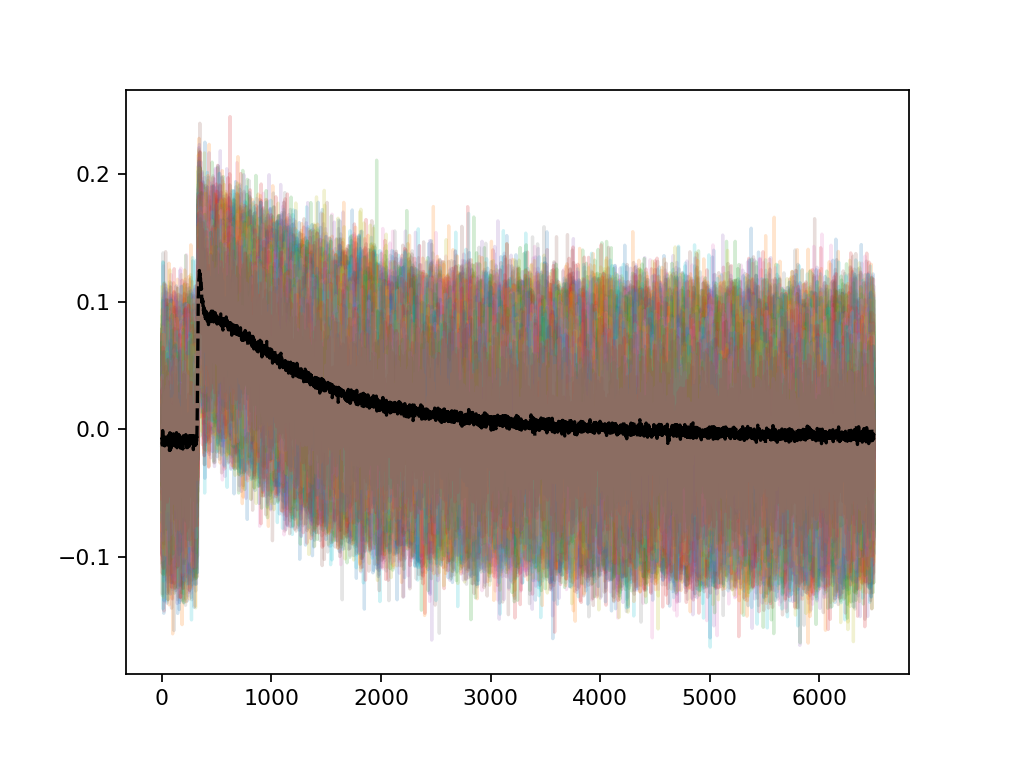

In [14]:
avg = StackPulses(res["Phase"],6.4215,win_fac=0.65,Npulses=225,bl_subtract=True,show_plots=True)
ax0 = plt.gca()
ax0.set_title("Phase Response")

<IPython.core.display.Javascript object>


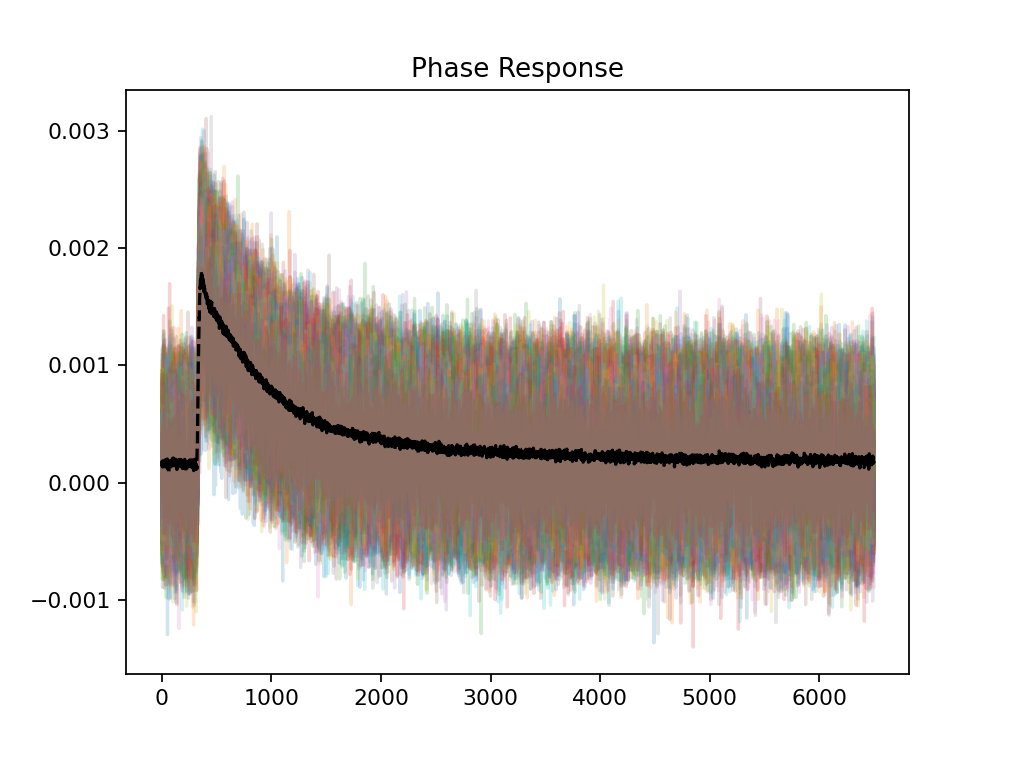

Text(0.5, 1.0, 'Phase Response')

In [16]:
avg = StackPulses(res["Magnitude"],6.4215,win_fac=0.65,Npulses=225,bl_subtract=True,show_plots=True)
ax0 = plt.gca()
ax0.set_title("Magnitude Response")

In [19]:
Ptt.PlotPulse(res["Phase"], 6.4215, p_index=0, fig_obj=None,
              pulse_rate_Hz=100, win_fac=0.65,
              baseline=None, complx=False)

NameError: name 'Ptt' is not defined

In [ ]:
Ptt.PlotPulse(res["Magnitude"], 6.4215, p_index=0, fig_obj=None,
              pulse_rate_Hz=100, win_fac=0.65,
              baseline=None, complx=False)

In [ ]:
Ptt.PlotPulse(res["Magnitude"]*np.exp(1j*res["Phase"]), 6.4215, p_index=0, fig_obj=None,
              pulse_rate_Hz=100, win_fac=0.65
              baseline=None, complx=True):